In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


In [4]:
# Load the dataset
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Display the first 5 records
df.head()


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,KM8K33AGXL,King,Seattle,WA,98103.0,2020,HYUNDAI,KONA,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,258,0,43.0,249675142,POINT (-122.34301 47.659185),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,1C4RJYB61N,King,Bothell,WA,98011.0,2022,JEEP,GRAND CHEROKEE,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,0,1.0,233928502,POINT (-122.20578 47.762405),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
2,1C4RJYD61P,Yakima,Yakima,WA,98908.0,2023,JEEP,GRAND CHEROKEE,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,0,14.0,229675939,POINT (-120.6027202 46.5965625),PACIFICORP,5.307700e+10
3,5YJ3E1EA7J,King,Kirkland,WA,98034.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,45.0,104714466,POINT (-122.209285 47.71124),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
4,WBY7Z8C5XJ,Thurston,Olympia,WA,98501.0,2018,BMW,I3,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,97,0,22.0,185498386,POINT (-122.89692 47.043535),PUGET SOUND ENERGY INC,5.306701e+10


In [5]:
# Check dataset structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150482 entries, 0 to 150481
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         150482 non-null  object 
 1   County                                             150479 non-null  object 
 2   City                                               150479 non-null  object 
 3   State                                              150482 non-null  object 
 4   Postal Code                                        150479 non-null  float64
 5   Model Year                                         150482 non-null  int64  
 6   Make                                               150482 non-null  object 
 7   Model                                              150482 non-null  object 
 8   Electric Vehicle Type                              150482 non-null  object

In [6]:
# Describe numeric data
df.describe()


,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,150479.000000,150482.000000,150482.000000,150482.000000,150141.000000,1.504820e+05,1.504790e+05
mean,98168.344154,2020.005436,67.877839,1312.644735,29.343950,2.111122e+08,5.297195e+10
std,2473.612184,3.015209,96.230009,9231.310215,14.824829,8.196388e+07,1.638841e+09
min,1730.000000,1997.000000,0.000000,0.000000,1.000000,4.385000e+03,1.081042e+09
25%,98052.000000,2018.000000,0.000000,0.000000,18.000000,1.693473e+08,5.303301e+10
50%,98122.000000,2021.000000,18.000000,0.000000,33.000000,2.150306e+08,5.303303e+10
75%,98370.000000,2023.000000,97.000000,0.000000,43.000000,2.399119e+08,5.305307e+10
max,99577.000000,2024.000000,337.000000,845000.000000,49.000000,4.792548e+08,5.603300e+10


In [8]:
# Check for null values
df.isnull().sum()


VIN (1-10)                                             0
County                                                 3
City                                                   3
State                                                  0
Postal Code                                            3
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 341
DOL Vehicle ID                                         0
Vehicle Location                                       7
Electric Utility                                       3
2020 Census Tract                                      3
dtype: int64

In [9]:
# Count total EVs registered per year
ev_by_year = df.groupby("Model Year").size().reset_index(name="Total EVs")

# Filter for training years: 2011–2023
ev_by_year = ev_by_year[(ev_by_year["Model Year"] >= 2011) & (ev_by_year["Model Year"] <= 2023)]

# Display trend data
ev_by_year


,Model Year,Total EVs
8,2011,796
9,2012,1633
10,2013,4566
11,2014,3613
12,2015,4934
13,2016,5650
14,2017,8574
15,2018,14441
16,2019,10717
17,2020,11294


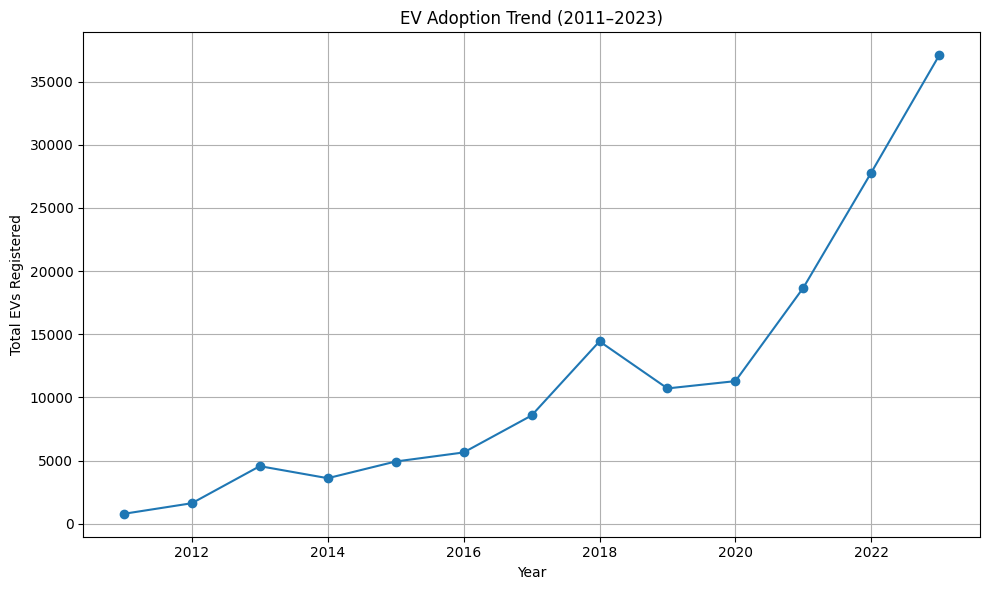

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(ev_by_year["Model Year"], ev_by_year["Total EVs"], marker='o', linestyle='-')
plt.title("EV Adoption Trend (2011–2023)")
plt.xlabel("Year")
plt.ylabel("Total EVs Registered")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Features and target
X = ev_by_year["Model Year"].values.reshape(-1, 1)
y = ev_by_year["Total EVs"].values

# Future years to forecast
future_years = np.array(range(2025, 2031)).reshape(-1, 1)


In [14]:
# Create and train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Predict EV registrations for future years (2025–2030)
y_pred_linear = linear_model.predict(future_years)

# Calculate RMSE for model performance on training data
# Calculate RMSE for model performance on training data
rmse_linear = np.sqrt(mean_squared_error(y, linear_model.predict(X)))

In [16]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(poly.transform(future_years))

rmse_poly = np.sqrt(mean_squared_error(y, poly_model.predict(X_poly)))

In [17]:
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(X, y)
y_pred_xgb = xgb_model.predict(future_years)

rmse_xgb = np.sqrt(mean_squared_error(y, xgb_model.predict(X)))

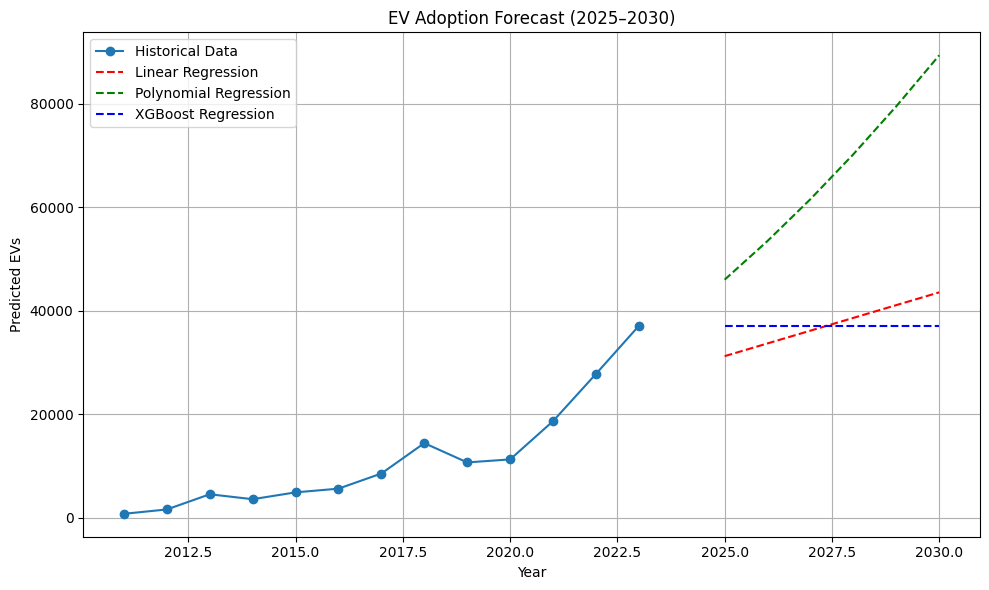

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(ev_by_year["Model Year"], y, 'o-', label='Historical Data')
plt.plot(future_years, y_pred_linear, 'r--', label='Linear Regression')
plt.plot(future_years, y_pred_poly, 'g--', label='Polynomial Regression')
plt.plot(future_years, y_pred_xgb, 'b--', label='XGBoost Regression')
plt.title("EV Adoption Forecast (2025–2030)")
plt.xlabel("Year")
plt.ylabel("Predicted EVs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
forecast_df = pd.DataFrame({
    "Year": future_years.flatten(),
    "Linear Prediction": y_pred_linear.astype(int),
    "Polynomial Prediction": y_pred_poly.astype(int),
    "XGBoost Prediction": y_pred_xgb.astype(int)
})

forecast_df


,Year,Linear Prediction,Polynomial Prediction,XGBoost Prediction
0,2025,31231,45997,37078
1,2026,33695,53481,37078
2,2027,36158,61556,37078
3,2028,38622,70222,37078
4,2029,41086,79478,37078
5,2030,43550,89325,37078


In [20]:
print("📉 RMSE Scores:")
print(f"Linear Regression: {rmse_linear:.2f}")
print(f"Polynomial Regression: {rmse_poly:.2f}")
print(f"XGBoost Regression: {rmse_xgb:.2f}")


📉 RMSE Scores:
Linear Regression: 4675.85
Polynomial Regression: 2903.85
XGBoost Regression: 0.00
